<h1 style="text-align: center">Hypothesis Testing with Men's and Women's Soccer Matches</h1>

<figure>
<img src="soccer-pitch.jpg" alt="A soccer pitch for an international match">
<figcaption style="font-size: 11px; text-align: center">A soccer pitch for an international match</figcaption>
</figure>  

As a sports journalist specializing in soccer analysis and reporting, your gut instinct tells you that more  
goals are scored in women's international football matches than men's.  

This would make an interesting investigative article that your subscribers are bound to love, but you'll   
need to perform a valid statistical hypothesis test to be sure!

Limit the data used in the analysis to only official `FIFA World Cup` matches (excluding qualifiers)  
since `2002-01-01`.

Data, containing the results of every official men's and women's international football match since the  
19th century, is stored in two CSV files: `women_results.csv` and `men_results.csv`.

Determine the answer to the question:

> Are more goals scored in women's international soccer matches than men's?

Assume a **10% significance level**, and also assume that each match is fully independent,  
i.e., team form is ignored. Use the following null and alternative hypotheses:

$H_0$ : The mean number of goals scored in women's international soccer matches is the same as men's.

$H_A$ : The mean number of goals scored in women's international soccer matches is greater than men's.

In [125]:
# Import required libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import pingouin
from scipy.stats import mannwhitneyu

# Change the default console output settings in NumPy and pandas to improve readability
pd.options.display.max_columns = 20
pd.options.display.max_rows = 20
pd.options.display.max_colwidth = 80
np.set_printoptions(precision=4, suppress=True)

In [126]:
# Load the men's dataset and preprocess 'date' column
men = pd.read_csv("data/men_results.csv", parse_dates=["date"], index_col=0)

# Load the women's dataset and preprocess 'date' column
women = pd.read_csv("data/women_results.csv", parse_dates=["date"], index_col=0)

**1. Exploratory data analysis**

In [127]:
# Check the column names and data types
men.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44353 entries, 0 to 44352
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        44353 non-null  datetime64[ns]
 1   home_team   44353 non-null  object        
 2   away_team   44353 non-null  object        
 3   home_score  44353 non-null  int64         
 4   away_score  44353 non-null  int64         
 5   tournament  44353 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 2.4+ MB


In [128]:
# Check the count of unique values in 'tournament' column
men["tournament"].value_counts()

tournament
Friendly                                17519
FIFA World Cup qualification             7878
UEFA Euro qualification                  2585
African Cup of Nations qualification     1932
FIFA World Cup                            964
                                        ...  
Real Madrid 75th Anniversary Cup            1
Évence Coppée Trophy                        1
Copa Confraternidad                         1
TIFOCO Tournament                           1
FIFA 75th Anniversary Cup                   1
Name: count, Length: 141, dtype: int64

In [129]:
# Check column names and data types
women.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4884 entries, 0 to 4883
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        4884 non-null   datetime64[ns]
 1   home_team   4884 non-null   object        
 2   away_team   4884 non-null   object        
 3   home_score  4884 non-null   int64         
 4   away_score  4884 non-null   int64         
 5   tournament  4884 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 267.1+ KB


In [130]:
# Check the count of unique values in 'tournament' column
women["tournament"].value_counts()

tournament
UEFA Euro qualification             1445
Algarve Cup                          551
FIFA World Cup                       284
AFC Championship                     268
Cyprus Cup                           258
                                    ... 
Tournament of Nations                 12
Tournoi de France                     12
CONCACAF Invitational Tournament       6
OFC Nations Cup qualification          6
Basque Country Women's Cup             4
Name: count, Length: 30, dtype: int64

**2. Filtering the data**

Filter the data to only include official FIFA World Cup matches that took place after 2002-01-01

In [131]:
# Filtering men's data for FIFA World Cup matches after 2002-01-01
men = men[(men["tournament"].isin(["FIFA World Cup"])) & (men["date"] > "2002-01-01")]

# Create 'group' and 'goals_scored' columns in the men's DataFrame
men["group"] = 'men'

men["goals_scored"] = men["home_score"] + men["away_score"]

men.head()

,date,home_team,away_team,home_score,away_score,tournament,group,goals_scored
25164,2002-05-31,France,Senegal,0,1,FIFA World Cup,men,1
25165,2002-06-01,Germany,Saudi Arabia,8,0,FIFA World Cup,men,8
25166,2002-06-01,Republic of Ireland,Cameroon,1,1,FIFA World Cup,men,2
25167,2002-06-01,Uruguay,Denmark,1,2,FIFA World Cup,men,3
25168,2002-06-02,Argentina,Nigeria,1,0,FIFA World Cup,men,1


In [132]:
# Filtering women's data for FIFA World Cup matches after 2002-01-01
women = women[(women["tournament"].isin(["FIFA World Cup"])) & (women["date"] > "2002-01-01")]

# Create 'group' and 'goals_scored' columns in the women's DataFrame
women["group"] = 'women'

women["goals_scored"] = women["home_score"] + women["away_score"]

women.head()

,date,home_team,away_team,home_score,away_score,tournament,group,goals_scored
1600,2003-09-20,Nigeria,North Korea,0,3,FIFA World Cup,women,3
1601,2003-09-20,Norway,France,2,0,FIFA World Cup,women,2
1602,2003-09-20,Germany,Canada,4,1,FIFA World Cup,women,5
1603,2003-09-20,Japan,Argentina,6,0,FIFA World Cup,women,6
1604,2003-09-21,United States,Sweden,3,1,FIFA World Cup,women,4


**3. Choosing the correct hypothesis test**

* Determining the type of hypothesis test

  * Because there are two independent groups, men's and women's, this scenario requires an unpaired  
    two-sample test.

  * An unpaired t-test and a Wilcoxon-Mann-Whitney test are the two most commmon two-sample tests,  
    where the Wilcoxon-Mann-Whitney test is a non-parametric version of the unpaired t-test.

  * To determine if a parametric or non-parametric test is appropriate, verify the underlying assumptions of  
  parametric tests, including checking the sample size in each group and the normality of each distribution.

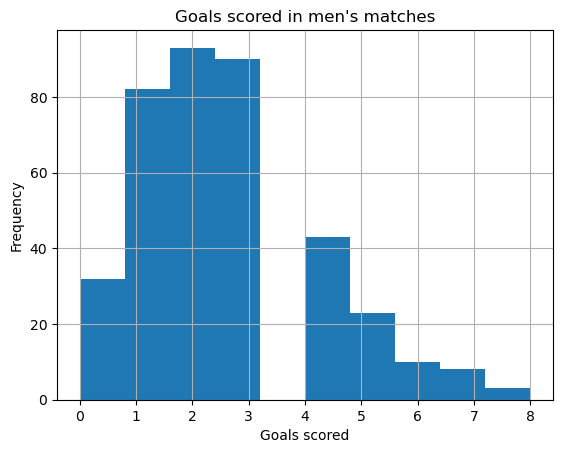

The men's dataset is not normally distributed.


In [133]:
# Check if men's data is normallly distributed
men["goals_scored"].hist()
plt.xlabel("Goals scored")
plt.ylabel("Frequency")
plt.title("Goals scored in men's matches")
plt.show()

print("The men's dataset is not normally distributed.")

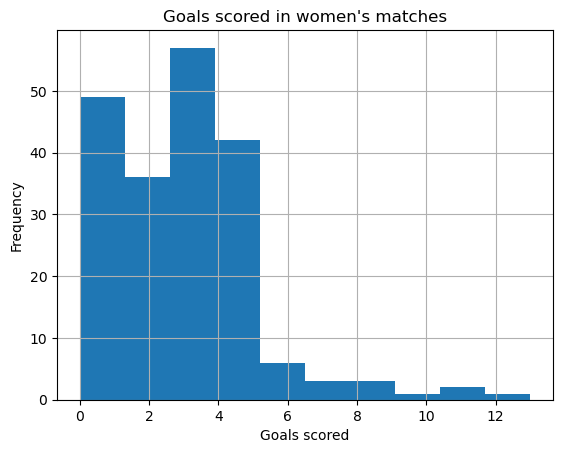

The women's dataset is not normally distributed.


In [134]:
# Check if women's data is normally distributed
women["goals_scored"].hist()
plt.xlabel("Goals scored")
plt.ylabel("Frequency")
plt.title("Goals scored in women's matches")
plt.show()

print("The women's dataset is not normally distributed.")

In [135]:
# Sample size of men's data
men_sample_size = len(men)

print(f"The men's dataset has a sample size of {men_sample_size}")

# Sample size of women's data
women_sample_size = len(women)

print(f"\nThe women's dataset has a sample size of {women_sample_size}")

The men's dataset has a sample size of 384

The women's dataset has a sample size of 200


An unpaired t-test (also known as an independent samples t-test) is used to compare the means of two  
independent groups. It's a parametric test, meaning it assumes that the data is normally distributed.   

A sample size of 30 or more is generally considered sufficient for many statistical tests, especially  
when the population distribution is approximately normal.

Since the data is not normally distributed, the non-parametric, Wilcoxon-Mann-Whitney test is more  
appropriate.

**4. Performing the hypothesis test**

**Method 1 - Using SciPy**

`scipy.stats.mannwhitneyu()` can be used to perform a Wilcoxon-Mann-Whitney test.  
It takes three arguments:

* `x`, the values suspected to be higher from the hypothesis,
* `y`, the values to compare against,
* `alternative`, an argument indicating whether the test is left-tailed, right-tailed, or two-tailed

In [ ]:
'''Alternative hypothesis: The mean number of goals scored in women's international soccer matches  
is greater than men's. Based on the alternative hypothesis, a right-tailed test is required.'''

results_scipy = mannwhitneyu(
    x=women["goals_scored"],  # The x argument takes the values suspected to be higher from the hypothesis
    y=men["goals_scored"],
    alternative="greater"
)

print(results_scipy)

MannwhitneyuResult(statistic=43273.0, pvalue=0.005106609825443641)


**Method 2 - Using pinguoin**

`pingouin.mwu()` can be used to perform a Wilcoxon-Mann-Whitney test. It takes three arguments:  

* `x`, the values from the pivoted table which are suspected to be higher from the hypothesis,
* `y`, the values to compare against,
* `alternative`, an argument indicating whether the test is left-tailed, right-tailed, or two-tailed

`pingouin.mwu()` requires a DataFrame pivoted to wide-format.

In [137]:
# Combine men's and women's data
both = pd.concat([men, women], axis=0, ignore_index=True)

both.head()

,date,home_team,away_team,home_score,away_score,tournament,group,goals_scored
0,2002-05-31,France,Senegal,0,1,FIFA World Cup,men,1
1,2002-06-01,Germany,Saudi Arabia,8,0,FIFA World Cup,men,8
2,2002-06-01,Republic of Ireland,Cameroon,1,1,FIFA World Cup,men,2
3,2002-06-01,Uruguay,Denmark,1,2,FIFA World Cup,men,3
4,2002-06-02,Argentina,Nigeria,1,0,FIFA World Cup,men,1


In [138]:
# Select only columns required for the test
both_subset = both[["group", "goals_scored"]]

both_subset.head()

,group,goals_scored
0,men,1
1,men,8
2,men,2
3,men,3
4,men,1


In [139]:
# Transform the DataFrame to wide-format
both_subset_wide = pd.pivot(data=both_subset, columns="group", values="goals_scored")

both_subset_wide.head()

group,men,women
0,1.0,NaN
1,8.0,NaN
2,2.0,NaN
3,3.0,NaN
4,1.0,NaN


In [ ]:
'''Alternative hypothesis: The mean number of goals scored in women's international soccer matches  
is greater than men's. Based on the alternative hypothesis, a right-tailed test is required.'''

result_pg = pingouin.mwu(
    x=both_subset_wide["women"],  # The x argument takes the values suspected to be higher from the hypothesis
    y=both_subset_wide["men"],
    alternative="greater"
)

print(result_pg)

       U-val alternative     p-val       RBC      CLES
MWU  43273.0     greater  0.005107  0.126901  0.563451


**5. Interpreting the result of the hypothesis test**

In [141]:
# Extract the p-value from the SciPy test
scipy_pval = results_scipy.pvalue

# Extract the p-value from the pingouin test
pingouin_pval = result_pg["p-val"].values[0]

print(f"p-value returned by the SciPy method: {scipy_pval}")

print(f"\np-value returned by the pingouin method: {pingouin_pval}")


p-value returned by the SciPy method: 0.005106609825443641

p-value returned by the pingouin method: 0.005106609825443641


Both methods returned the same result and either method may be used to find the p-value used to  
determine the results of the hypothesis test.

Based on the initial assumption of a 10% significance level:

* If $p-value \le 0.1 $, reject the null hypothesis, otherwise, fail to reject it.

In [142]:
# Determine the hypothesis test result
if scipy_pval <= 0.1:
    result = "Reject the null hypothesis"
else:
    result = "Fail to reject the null hypothesis"

result_dict = {"p-value": scipy_pval, "result": result}

print(result_dict)

{'p-value': 0.005106609825443641, 'result': 'Reject the null hypothesis'}


**Hypothesis test result:**  

The mean number of goals scored in women's international soccer matches is greater than men's.

<div style="text-align: center; font-size: 18px; font-weight: bold; color: #007BFF;">
<span>[ End of notebook ]</span>
</div>